In [1]:
#!pip install climpred==2.2.0

In [ ]:
#!pip install numpy==1.22

In [2]:
#!pip install xclim

In [3]:
#!pip install bias_correction

In [1]:
import climpred

In [2]:
import xarray as xr

In [6]:
#climpred.show_versions()

In [4]:
obs = xr.open_dataset("/data/volume_2/observational/preprocessed/chirps_tp_2000-2020_4weekly_0.25deg_africa.nc", use_cftime=True)

In [5]:
obs # metadata missing # dataarray/variable name missing

<xarray.Dataset>
Dimensions:                        (latitude: 292, longitude: 278,
                                    valid_time: 1113)
Coordinates:
  * latitude                       (latitude) float64 -35.38 -35.12 ... 37.38
  * longitude                      (longitude) float64 -17.88 -17.62 ... 51.38
  * valid_time                     (valid_time) object 2000-01-17 00:00:00 .....
Data variables:
    __xarray_dataarray_variable__  (valid_time, latitude, longitude) float32 ...

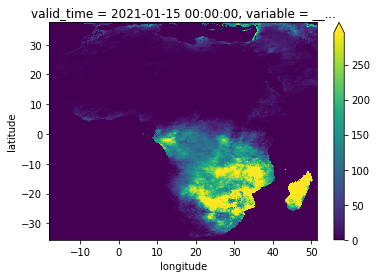

In [6]:
obs.isel(valid_time=-1).to_array().plot(robust=True)

`climpred` observations requires dimension `time`: https://climpred.readthedocs.io/en/stable/setting-up-data.html

In [7]:
obs = obs.rename({"valid_time":"time"})

In [8]:
init = xr.open_dataset("/data/volume_2/subseasonal/ecmwf/aggregated/hindcast/ecmwf-hindcast-tp-week3456.nc", use_cftime=True)

In [9]:
init

<xarray.Dataset>
Dimensions:                        (realization: 11, latitude: 121,
                                    longitude: 240, valid_time: 1060)
Coordinates:
  * realization                    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * latitude                       (latitude) float64 90.0 88.5 ... -88.5 -90.0
  * longitude                      (longitude) float64 0.0 1.5 ... 357.0 358.5
  * valid_time                     (valid_time) object 2000-01-17 00:00:00 .....
Data variables:
    __xarray_dataarray_variable__  (valid_time, realization, latitude, longitude) float32 ...

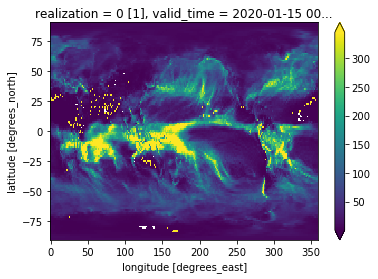

In [10]:
init.isel(realization=0,valid_time=-1).to_array().plot(robust=True)

`climpred` requires dimensions `init` as `forecast_reference_time` and `lead` as `forecast_period`: https://climpred.readthedocs.io/en/stable/setting-up-data.html

In [11]:
import pandas as pd
lead = pd.Timedelta("14 days")
# drop valid_time which gets recreated by HindcastEnsemble
init = init.assign_coords(lead=[lead], init=init.valid_time-lead).swap_dims({"valid_time":"init"}).drop("valid_time")

In [12]:
init 

<xarray.Dataset>
Dimensions:                        (realization: 11, latitude: 121,
                                    longitude: 240, init: 1060, lead: 1)
Coordinates:
  * realization                    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * latitude                       (latitude) float64 90.0 88.5 ... -88.5 -90.0
  * longitude                      (longitude) float64 0.0 1.5 ... 357.0 358.5
  * lead                           (lead) timedelta64[ns] 14 days
  * init                           (init) object 2000-01-03 00:00:00 ... 2020...
Data variables:
    __xarray_dataarray_variable__  (init, realization, latitude, longitude) float32 ...

In [13]:
# subselect africa
init = init.sel(longitude=slice(0,52),latitude=slice(38,-36)) #  lat -36,38 should have worked but didnt

In [14]:
# interpolate on same grid
# init = init.interp_like(obs) # all 0.25 deg
obs = obs.interp_like(init).astype("float32") # all 1.5 deg

In [15]:
he = climpred.HindcastEnsemble(init).add_observations(obs)

/home/aspring/.local/lib/python3.8/site-packages/climpred/checks.py:202: UserWarning: Did not find dimension "member", but renamed dimension realization with CF-complying standard_name "realization" to member.
  warnings.warn(
/home/aspring/.local/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [16]:
# metadata added by cf-xarray
he

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (member: 11, latitude: 50, longitude: 35,
 init: 1060, lead: 1)
Coordinates:
 * member (member) int64 0 1 2 3 4 5 6 7 8 9 10
 * latitude (latitude) float64 37.5 36.0 ... -34.5 -36.0
 * longitude (longitude) float64 0.0 1.5 3.0 ... 49.5 51.0
 * lead (lead) float64 2.0
 * init (init) object 2000-01-03 00:00:00 ... 2020...
 valid_time (lead, init) object 2000-01-17 00:00:00 .....
Data variables:
 __xarray_dataarray_variable__ (init, member, latitude, longitude) float32 ... Initialized Ensemble Dimensions: member : 11 latitude : 50 longitude : 35 init : 1060 lead : 1 Coordinates: (6) member (member) int64 0 1 2 3 4 5 6 7 8 9 10 long_name : Member units : 1 standard_name : realization description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) latitude (latitude) float64 37.5 36.0 34.5 ... -34.5 -36.0 units : degrees_north standard_name : latitude long_name : latitude stored_direction : decreasing amip : latitude description : Latitude is positive northward; its units of degree_north (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_latitude should be used instead of latitude. Grid latitude is positive in the grid-northward direction, but its units should be plain degree. array([ 37.5, 36. , 34.5, 33. , 31.5, 30. , 28.5, 27. , 25.5, 24. ,
 22.5, 21. , 19.5, 18. , 16.5, 15. , 13.5, 12. , 10.5, 9. ,
 7.5, 6. , 4.5, 3. , 1.5, 0. , -1.5, -3. , -4.5, -6. ,
 -7.5, -9. , -10.5, -12. , -13.5, -15. , -16.5, -18. , -19.5, -21. ,
 -22.5, -24. , -25.5, -27. , -28.5, -30. , -31.5, -33. , -34.5, -36. ]) longitude (longitude) float64 0.0 1.5 3.0 4.5 ... 48.0 49.5 51.0 units : degrees_east standard_name : longitude long_name : longitude amip : longitude description : Longitude is positive eastward; its units of degree_east (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_longitude should be used instead of longitude. Grid longitude is positive in the grid-eastward direction, but its units should be plain degree. array([ 0. , 1.5, 3. , 4.5, 6. , 7.5, 9. , 10.5, 12. , 13.5, 15. , 16.5,
 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5,
 36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. , 49.5, 51. ]) lead (lead) float64 2.0 units : weeks standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([2.]) init (init) object 2000-01-03 00:00:00 ... 2020-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(2000, 1, 3, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 10, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 17, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2019, 12, 18, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2019, 12, 25, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2020, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) valid_time (lead, init) object 2000-01-17 00:00:00 ... 2020-01-... long_name : validity time standard_name : time description : time for which the forecast is valid calculate : init + lead amip : time array([[cftime.DatetimeProlepticGregorian(2000, 1, 17, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 24, 0, 0, 0, 0, has

<Observations>
Dimensions: (time: 1113, latitude: 50, longitude: 35)
Coordinates:
 * time (time) object 2000-01-17 00:00:00 ... 2021...
 * latitude (latitude) float64 37.5 36.0 ... -34.5 -36.0
 * longitude (longitude) float64 0.0 1.5 3.0 ... 49.5 51.0
Data variables:
 __xarray_dataarray_variable__ (time, latitude, longitude) float32 nan ..... Observations Dimensions: time : 1113 latitude : 50 longitude : 35 Coordinates: (3) time (time) object 2000-01-17 00:00:00 ... 2021-01-... array([cftime.DatetimeProlepticGregorian(2000, 1, 17, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 24, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 31, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2021, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2021, 1, 8, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2021, 1, 15, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) latitude (latitude) float64 37.5 36.0 34.5 ... -34.5 -36.0 units : degrees_north standard_name : latitude long_name : latitude stored_direction : decreasing array([ 37.5, 36. , 34.5, 33. , 31.5, 30. , 28.5, 27. , 25.5, 24. ,
 22.5, 21. , 19.5, 18. , 16.5, 15. , 13.5, 12. , 10.5, 9. ,
 7.5, 6. , 4.5, 3. , 1.5, 0. , -1.5, -3. , -4.5, -6. ,
 -7.5, -9. , -10.5, -12. , -13.5, -15. , -16.5, -18. , -19.5, -21. ,
 -22.5, -24. , -25.5, -27. , -28.5, -30. , -31.5, -33. , -34.5, -36. ]) longitude (longitude) float64 0.0 1.5 3.0 4.5 ... 48.0 49.5 51.0 units : degrees_east standard_name : longitude long_name : longitude array([ 0. , 1.5, 3. , 4.5, 6. , 7.5, 9. , 10.5, 12. , 13.5, 15. , 16.5,
 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5,
 36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. , 49.5, 51. ]) Data variables: (1) __xarray_dataarray_variable__ (time, latitude, longitude) float32 nan nan nan nan ... nan nan nan nan standard_name : convective precipitation rate long_name : Climate Hazards group InfraRed Precipitation with Stations units : mm time_step : 4_week_accumulation geostatial_lat_min : -50.0 geostatial_lat_max : 50.0 geostatial_lon_min : -180.0 geostatial_lon_max : 180.0 array([[[ nan, nan, nan, ..., nan,
 nan, nan],
 [ 4.2247047, 14.094817 , 25.252491 , ..., 58.63185 ,
 177.98346 , 163.4406 ],
 [ 12.795706 , 11.550631 , 10.167349 , ..., 48.480824 ,
 60.861137 , 25.025085 ],
 ...,
 [ 0. , 0. , 0. , ..., 0. ,
 0. , 0. ],
 [ 0. , 0. , 0. , ..., 0. ,
 0. , 0. ],
 [ nan, nan, nan, ..., nan,
 nan, nan]],

 [[ nan, nan, nan, ..., nan,
 nan, nan],
 [ 4.2247047, 9.590516 , 18.543541 , ..., 58.63185 ,
 177.98346 , 167.14621 ],
 [ 12.795706 , 11.550631 , 4.847823 , ..., 49.678337 ,
 60.861137 , 29.243073 ],
...
 [ 0. , 0. , 0. , ..., 0. ,
 0. , 0. ],
 [ 0. , 0. , 0. , ..., 0. ,
 0. , 0. ],
 [ nan, nan, nan, ..., nan,
 nan, nan]],

 [[ nan, nan, nan, ..., nan,
 nan, nan],
 [ 8.115257 , 31.206917 , 87.28843 , ..., 39.020096 ,
 115.91663 , 100.98237 ],
 [ 18.042122 , 12.768827 , 9.600269 , ..., 42.650036 ,
 35.716236 , 14.996954 ],
 ...,
 [ 0. , 0. , 0. , ..., 0. ,
 0. , 0. ],
 [ 0. , 0. , 0. , ..., 0. ,
 0. , 0. ],
 [ nan, nan, nan, ..., nan,
 nan, nan]]], dtype=float32) Attributes: (0)

In [17]:
# alternatively regrid on same grid with climpred wrapping xesmf
# he.smooth({"latitude":1.5, "longitude":1.5})

In [31]:
# skill https://climpred.readthedocs.io/en/stable/api/climpred.classes.HindcastEnsemble.verify.html#climpred.classes.HindcastEnsemble.verify
%time skill = he.verify(metric='crps', comparison='m2o', dim='member', alignment='same_verifs', reference=["climatology", "persistence"])

CPU times: user 3.31 s, sys: 104 ms, total: 3.42 s
Wall time: 3.43 s


In [32]:
skill

<xarray.Dataset>
Dimensions:                        (skill: 3, init: 990, latitude: 50,
                                    longitude: 35)
Coordinates:
  * init                           (init) object 2000-01-17 00:00:00 ... 2020...
  * latitude                       (latitude) float64 37.5 36.0 ... -34.5 -36.0
  * longitude                      (longitude) float64 0.0 1.5 3.0 ... 49.5 51.0
    lead                           float64 2.0
    valid_time                     (init) object 2000-01-31 00:00:00 ... 2020...
  * skill                          (skill) <U11 'initialized' ... 'persistence'
Data variables:
    __xarray_dataarray_variable__  (skill, init, latitude, longitude) float64 ...
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_members:             11
    alignment:                     same_verifs
    metric:                        crps
    comparison:                    m2o
    dim:                           member
    reference:                     ['climatology', 'persistence']

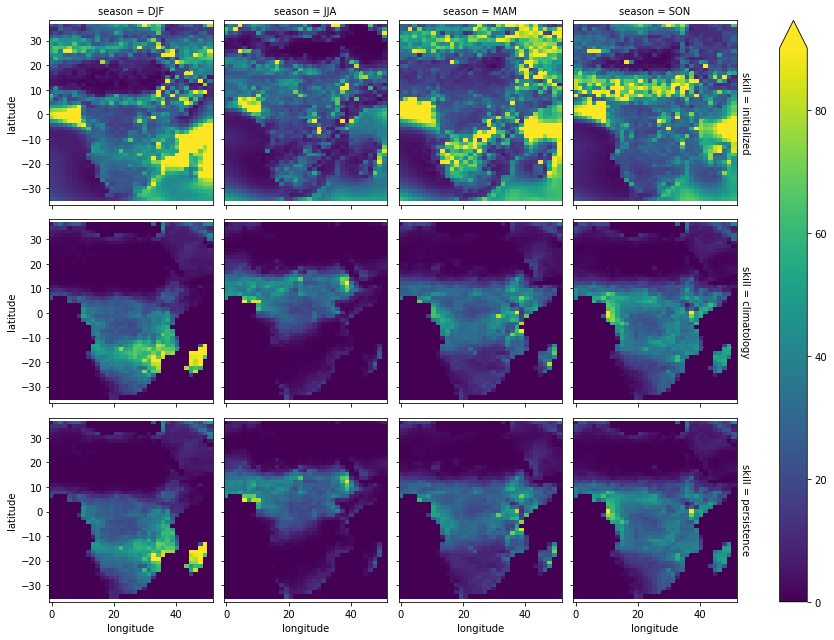

In [33]:
skill.groupby("init.season").mean().to_array().plot(robust=True,col="season",row="skill")

In [50]:
# do some bias reduction before skill
%time he_bias_removed = he.fillna(0.).remove_bias(how="basic_quantile", alignment="same_verifs")
# fixing https://github.com/pangeo-data/climpred/issues/771
he_bias_removed._datasets["initialized"] = he_bias_removed._datasets["initialized"].assign_coords(lead=he.coords["lead"],valid_time=he.coords["valid_time"])#.verify(metric='crps', comparison='m2o', dim='member', alignment='same_verifs', reference="climatology").groupby("init.season").mean().to_array().plot(robust=True,col="season",row="skill")

CPU times: user 46.9 s, sys: 212 ms, total: 47.1 s
Wall time: 51 s


In [51]:
# quick fix pos precip
he_bias_removed._datasets["initialized"] = he_bias_removed._datasets["initialized"].where(he_bias_removed._datasets["initialized"]>0, other=0)

In [52]:
# kernel fails for all inits somehow
bias_removed_skill = he_bias_removed.sel(init=slice("2000","2008")).verify(metric='crps', comparison='m2o', dim='member', alignment='same_verifs', reference=["climatology", "persistence"])

/home/aspring/.local/lib/python3.8/site-packages/climpred/classes.py:713: UserWarning: Error due to verification/control/uninitialized: xr.sel((), {'init': slice('2000', '2008', None)}) failed
KeyError: "'init' is not a valid dimension or coordinate"
  warnings.warn(


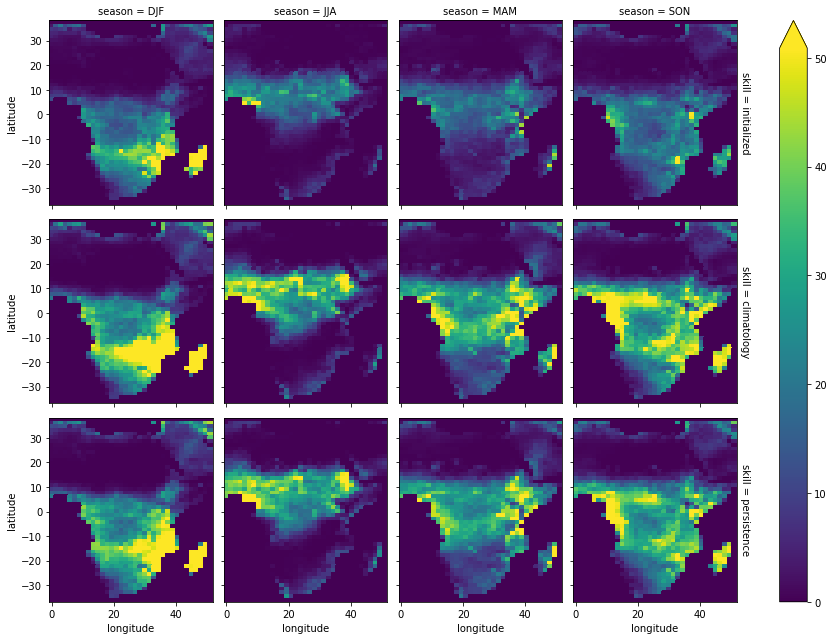

In [53]:
bias_removed_skill.groupby("init.season").mean().to_array().plot(robust=True,col="season",row="skill")

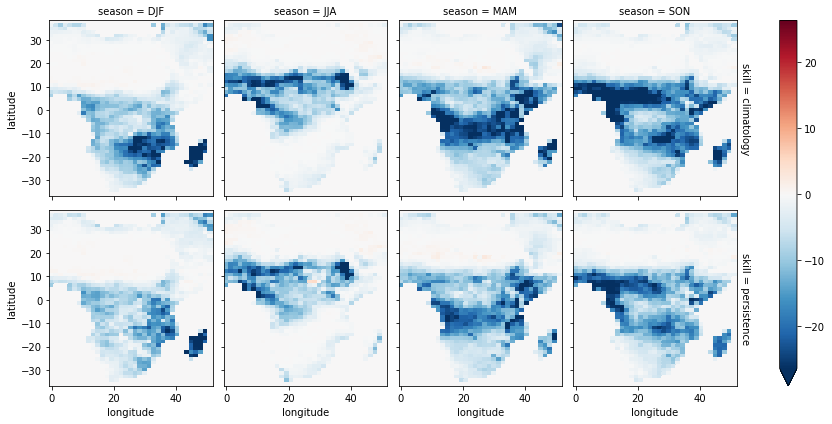

In [54]:
# absolute skill improvement over reference in blue
bias_removed_skill_seas = bias_removed_skill.groupby("init.season").mean().to_array()
(bias_removed_skill_seas.sel(skill="initialized") - bias_removed_skill_seas.drop_sel(skill="initialized")).plot(robust=True,col="season",row="skill")

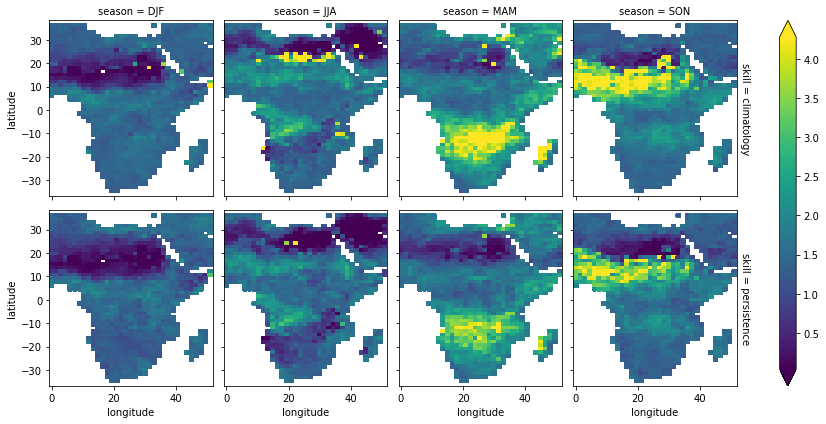

In [55]:
# skill improvement factor
(bias_removed_skill_seas.drop_sel(skill="initialized")/bias_removed_skill_seas.sel(skill="initialized")).plot(robust=True,col="season",row="skill")